**Лабораторная работа №3**
# <b>Проверка статистических гипотез</b> 

## Библиотеки
- numpy: 2.2.2
- pandas: 2.2.3
- scipy: 1.15.1
- statsmodels: 1.15.1
- matplotlib: 1.15.1
- seaborn: 0.13.2


In [2]:
import scipy
import statsmodels
import matplotlib

import itertools
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.diagnostic import kstest_normal
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import binom_test
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.proportion import binom_test, proportions_ztest, proportions_chisquare
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.descriptivestats import sign_test

# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

versions = f'''
- numpy: {np.__version__}
- pandas: {pd.__version__}
- scipy: {scipy.__version__}
- statsmodels: {scipy.__version__}
- matplotlib: {scipy.__version__}
- seaborn: {sns.__version__}
'''
print(versions)



- numpy: 2.2.5
- pandas: 2.2.3
- scipy: 1.15.3
- statsmodels: 1.15.3
- matplotlib: 1.15.3
- seaborn: 0.13.2



In [3]:
# перестановочный критерий
# from permute.core import one_sample, two_sample

# критерий знаков

# для перестановок

# бутстрап
# from arch.bootstrap import IIDBootstrap

## <b><font color="red">I. Семинарская часть</font></b> 

### 1.1 Параметрические гипотезы

#### **Пример 1. Гипотеза о математическом ожидании нормального распределения (Kanji, критерий 1)**

Линия по производству пудры должна обеспечивать средний вес пудры в упаковке 4 грамма, заявленное стандартное отклонение — 1 грамм.
В ходе инспекции выбрано 9 упаковок, средний вес продукта в них составляет 4.6 грамма.

Соответствуют ли норме результаты инспекции на уровне значимости $\alpha=0.05$?

**Решение**
Введем гипотезы:
* $H_0$: средний вес пудры в упаковке соответствует норме.
* $H_1$: средний вес пудры в упаковке не соответствует норме (двухсторонняя альтернативная гиптоеза)

```p=0.0719```


In [4]:
def check_hipotesis(p,alpha=0.05):
    if p<alpha:
        print('Нулевая гипотеза должна быть отвергнута в пользу альтерантивы')
        return True
    else:
        print('Нулевая гипотеза не противоречит наблюдаемым данным')
        return False


In [5]:
# Исходные данные:
mu = 4 # Теоретическое математическое ожидание
std = 1 # Теоретическое СКО
n = 9 # Объем выборки
mean = 4.6 # Выборочное среднее
alpha = 0.05 # уровень значимости

1. Выполним проверку гипотезы **вручную**:

Так как гипотеза о среднем и дисперсии известны - имспользуем Z-критерий:

$$
    Z = \frac{\bar{X}-\mu}{\sigma/\sqrt{n}}.
$$

Так как альтернативная гипотеза двухстороняя $p$-значение вычисляетмся по формуле:
$$
p(Z) = 2 \bigl(1-F(|Z|)\bigr).
$$

In [6]:
#Z = # ваш код 
Z = (mean - mu)/(std/np.sqrt(n))
Z

np.float64(1.799999999999999)

In [7]:
p = 2*(1-st.norm.cdf(np.abs(Z))) # ваш код
p

np.float64(0.07186063822585176)

In [8]:
check_hipotesis(p,alpha);

Нулевая гипотеза не противоречит наблюдаемым данным


2. Выполним проверку гипотезы **с использованием библиотеки ```statsmodels```**


Для этого просэмплируем выборку из нормального распределения (!) с нашими выборочным средним и СКО

In [9]:
np.random.seed(42)

# Сформируем выборку:
X = np.random.randn(n) * std + mean
print(f'mean={np.mean(X)}, std={np.std(X)}')

empirical_Z, pvalue = ztest(X, value = mu, alternative = "two-sided")  # Первая компонента - эмпирическое значение критерия, вторая - p-значение
print(f'Z={empirical_Z}, p={pvalue:.5f}')
check_hipotesis(pvalue,alpha);

mean=5.037561230377956, std=0.7222455089229228
Z=4.063253133913534, p=0.00005
Нулевая гипотеза должна быть отвергнута в пользу альтерантивы


In [10]:
np.random.seed(24)

# Сформируем выборку:
X = np.random.randn(n) * std + mean
print(f'mean={np.mean(X)}, std={np.std(X)}')

empirical_Z, pvalue = ztest(X, value = mu, alternative = "two-sided")  # Первая компонента - эмпирическое значение критерия, вторая - p-значение
print(f'Z={empirical_Z}, p={pvalue:.5f}')
check_hipotesis(pvalue,alpha);

mean=4.152921438306466, std=0.9375105181307597
Z=0.46135711087657605, p=0.64454
Нулевая гипотеза не противоречит наблюдаемым данным


#### **Пример 2. Гипотеза о доле нормального распределения [Кобзарь, c. 437, задача 227]** 

Нормируемый уровень дефектных изделий в партии $p_0 = 0.05$. 
Из партии извлечена выборка $n=20$ изделий, среди которых обнаружено 2 дефектных.
Требуется ли отзыв партии на уровне значимости $\alpha = 0.05$?



**Обратите внимание:**
- В этой ситуации плохо, если доля баркованых деталей больше допусимой, поэтому альтернативная гипотеза будет односторонней.
- Распределение дискретно, вероятность брака фиксирована ($p_0=0.05$), причем брак одной детали не влияет на наличие брака в другой детали, поэтому **биномиальное**

**Гипотезы**
- $H_0$ : доля дефектных изделий в партии не выше нормы.

- $H_1$ : доля дефектных изделий в партии выше нормы.


**Решение 1.** Ручная проверка гипотезы для биномиального распределения

В качестве статистики возьмем величину
$$
T = \sum X_i
$$

p-значение для правосторонней гипотезы вычисляется как
$$
    p(T) = 1 - F(T)
$$ 

Функцию биномиального распределения можно вычислить 
как 
```st.binom.cdf()```


In [11]:
n = 20
p0 = 0.05

T = 2 # ваш код

In [12]:
p = 1 - st.binom(n=n, p=p0).cdf(T - 1)  # ваш код
p

np.float64(0.2641604750561498)

Вариант решения 1. В предположении о нормальности рспределения:
Так как партия достаточно большая, чтобы Распределение можно считать приближенно нормальным Поэтому распределение можно считать нормальным

Статистика для проверки гипотезы о доле носителей признака в нормальном распределении имеет вид
$$
    Z = \frac{w-p_0}{\sqrt{{p_0q_0}/{n}}} \sim N(0,1)
$$
P


**Решение 2** Проверим критерий с использованием библиотеки ```scipy```.

In [13]:
st.binomtest(T, n, p0, alternative='greater')

BinomTestResult(k=2, n=20, alternative='greater', statistic=0.1, pvalue=0.2641604750561498)

**Решение 3** Проверим критерий с использованием библиотеки  ```statsmodels```

In [14]:
binom_test(T, n, p0, alternative='larger')

np.float64(0.2641604750561498)

#### **Пример 3. Метилфенидат и синдром дефицита внимания**
**Pearson D.A, Santos C.W., Casat C.D., et al. (2004). Treatment effects of methylphenidate on cognitive functioning in children with mental retardation and ADHD. Journal of the American Academy of Child and Adolescent Psychiatry, 43(6), 677–685.**


24 умственно отсталых ребёнка с СДВГ (Синдром дефицита внимания с гиперактивностью) в течение недели принимали либо метилфенидат, либо плацебо, а в конце недели проходили тест на способность к подавлению импульсивных поведенческих реакций. 
На втором этапе плацебо и препарат менялись, после недельного курса каждый испытуемые проходили второй тест.

Каков эффект препарата?

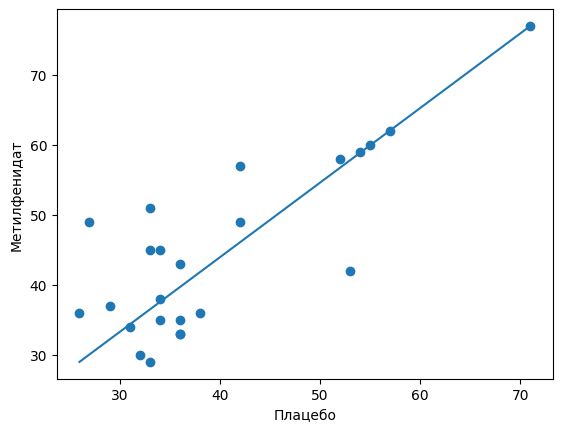

In [15]:
data = [ 
    [57, 62], [27, 49], [32, 30], [31, 34], [34, 38], [38, 36], [71, 77], [33, 51], [34, 45], [53, 42], [36, 43], [42, 57], [26, 36], [52, 58], [36, 35], [55, 60], [36, 33], [42, 49], [36, 33], [54, 59], [34, 35], [29, 37], [33, 45], [33, 29],
]

data = pd.DataFrame(data = data,columns=['D0','D60'])


plt.scatter(data.iloc[:, 0], data.iloc[:, 1])
plt.xlabel('Плацебо')
plt.ylabel('Метилфенидат')
plt.plot([min(data.iloc[:,0]), max(data.iloc[:,0])], [min(data.iloc[:,1]), max(data.iloc[:,1])])

plt.show()

**Сформулируем гипотезы:**
* $H_0$ - Математические ожидания равны - эффекта нет
* $H_1$ - Математические ожидания статистически различны - эффект есть

Для их проверки нам потребуется критерий Стьюдента для связанных выборок.
Однако од сформулирован для нормального распределения. Проверим, нет ли существенных отклонений от нормальности попарных разностей:

**Проверка нормальности** 

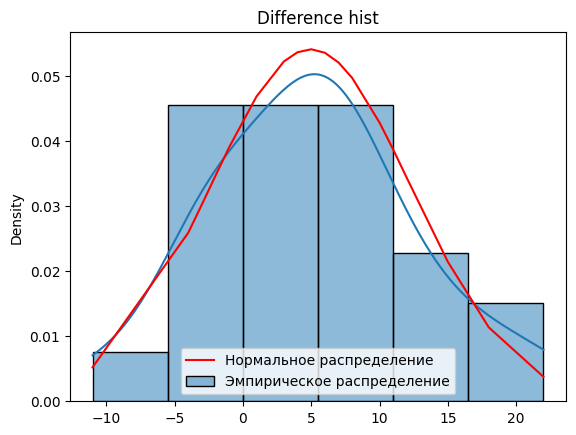

In [16]:
deltas = data.loc[:,'D60'] - data.loc[:,'D0']
sns.histplot(deltas, label='Эмпирическое распределение',stat='density',kde=True)
plt.plot(sorted(deltas), st.distributions.norm(np.mean(deltas), np.std(deltas)).pdf(sorted(deltas)), label='Нормальное распределение', c='red')
plt.legend(loc='best')
plt.title('Difference hist')

plt.show()

Построим **Q-Q диаграмы**

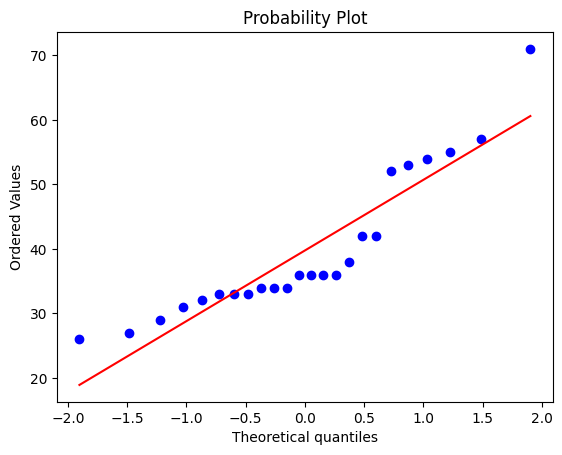

In [17]:
_ = st.probplot(data.iloc[:,0], plot=plt,dist='norm')
plt.show()


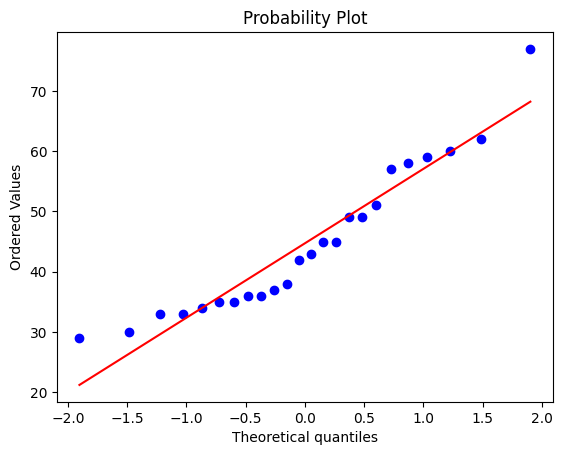

In [18]:
_ = st.probplot(data.iloc[:,1], plot=plt,dist='norm')
plt.show()


Применим **критерий Шапиро-Уилка**

In [19]:
data.apply(lambda col: st.shapiro(col).pvalue, axis=0)


D0     0.003020
D60    0.048768
dtype: float64

In [20]:
st.shapiro(deltas).pvalue

np.float64(0.8922548070861912)

Тест Шапиро-Уилка дает p-значения для каждой выборки дает p-значения меньшие 0.05, поэтому можно применять критерий Стьюдента с риском 5%.

Его вычисление для связанных выборок можно выполнять функцией ```scipy.stats.ttest_rel```, а для несвязанных - функцией ``` scipy.stats.ttest_ind```.

Так как выборки связаны имеем:

In [21]:
A = data.loc[:,'D0'].values
B = data.loc[:,'D60'].values

pval_rel = st.ttest_rel(a=A, b=B).pvalue
print(f'p-значение для связанных выборок: {pval_rel:.5f}')


p-значение для связанных выборок: 0.00377


Гипотезу об отсутствии эффекта отвергаем на уровне значимости $\alpha=0.05$ так как $0.0038<0.05$.

Заметим, что отсутствие эффекта отвергается даже на принятом в медицине уровне значимости $\alpha=0.005$

Если бы у нас не было информации о связях между выборками, пришлось бы применять версию критерия Стьюдента для независимых выборок:



In [22]:
pval = st.ttest_ind(A, B).pvalue
print(f'p-значение для независимых выборок: {pval:.5f}')


p-значение для независимых выборок: 0.15324


Как видите, в этом случае отсутствие эффекта не противоречит наблюдениям!

### **Пример 4. Мышки с зеркалами**

16 лабораторных мышей были помещены в двухкомнатные клетки, в одной из комнат висело зеркало. 
Измерялась доля времени, которое каждая мышь проводила в каждой из своих двух клеток.

Внимание, вопрос: любят ли мыши вертеться перед зеркалом?

Ниже приведены данные о доле времени, которые мышь провелав комнате с зеркалом

In [23]:
# Данные
data = np.array([
    0.3484705,  0.6406202,  0.5498178,  0.5374537,  0.4004438,  0.4262919,  0.4171558,  0.4779768,  
    0.4506574,  0.4766018,  0.4886766,  0.4847412,  0.4816139,  0.4894059,  0.4673653,  0.4673297, 
])
length_data = data.shape[0]
data


array([0.3484705, 0.6406202, 0.5498178, 0.5374537, 0.4004438, 0.4262919,
       0.4171558, 0.4779768, 0.4506574, 0.4766018, 0.4886766, 0.4847412,
       0.4816139, 0.4894059, 0.4673653, 0.4673297])

#### Гистограмма распределения

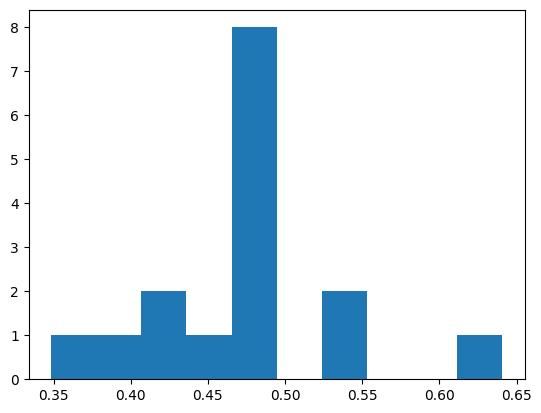

In [24]:
plt.hist(data)
plt.show()

*Гипотезы*:
* $H_0$: мышам всё равно, висит в клетке зеркало или нет.
* $H_1$: у мышей есть какие-то предпочтения насчёт зеркала.

*Формализованные гипотезы*:
* $H_0$: математическое ожидание времени в клетке с зералом равняется 0.5 $\mathsf{E}X = 0.5$.
* $H_1$: математическое ожидание времени в клетке с зералом не равняется 0.5 $\mathsf{E}X \neq 0.5$

Для проверки гипотезы 

1. Порпобуем использовать **биномиальный тест**

In [25]:
binomtest_pval = st.binomtest(np.sum(data>0.5), length_data, alternative='two-sided').pvalue
binomtest_pval

np.float64(0.021270751953125)

2. Применим **критерий знаков**

In [26]:
signtest_pval = sign_test(data, mu0=0.5)[1]
signtest_pval

np.float64(0.021270751953125)

3. Рассмотрим **перестановочный критерий**:

Вычислим статистику $T = \sum_{i=1}^{16}(X_i-0.5)$

In [27]:
t = (data - 0.5)
T = np.sum(t)
T

np.float64(-0.39537769999999994)

Перечислим всевозможные способы расстановки знаков перед слагаемыми в сумме $\tilde{T} = \sum_{i=1}^{16} \pm(X_i-0.5)$


In [28]:
L = list(itertools.product([-1, 1], repeat=16))
count = len(L)

Вычислим всевозможные суммы с учетом знаков

In [29]:
stat = np.array([np.dot(t, v) for v in L])

Посчитаем количество значений больших, чем $|T|$.

In [30]:
good  = sum(stat>=abs(T))

Применим формулу классической вероятности

In [31]:
permut_pval = good/count
permut_pval

np.float64(0.078887939453125)

4. Наконец, воспользуемся **бутстреп**-методом:


In [32]:
# наблюдаемое значение доли времени в комнате с зеркалом
mean = data.mean()
print(f'Наблюдаемое среднее: {mean}')

# Сформируем псевдовыборки
rs = np.random.RandomState(0)
samples_idx = rs.randint(low=0, high=16, size=(1000, 16))

# Вычислим среднее в каждой выборке
results = [data[idxs].mean() for idxs in samples_idx ]

#Вычислим левую и правую границы доверительного интервала с надежностью 0.95 
interval = np.quantile(results,[0.025,0.975])
print(f'Доверительный интервал: {interval}')


Наблюдаемое среднее: 0.47528889375
Доверительный интервал: [0.44498474 0.50910533]


Нулевая гипотеза отвергается, если гипотетическое значение не попадает в доверительный интервал

В нашем случае $0.5 \in [0.445, 0.509]$, то есть нет оснований отвергать нулевую гипотезу

## <b><font color="red">II. Задания на лабораторную работу</font></b> 

### **Задание 1. Хмельной Бонд (гипотеза о доле)**  

Пусть Бонд выбрал взболтанный мартини в 12 случаев из 16.

Требуется:

1. Проверить гипотезу о равнозначности мартини методами ```binom_test```, ```proportions_chisquare```, 
```proportions_ztest```.
2. Провести симуляцию и построить зависимость мощности $\beta$ критерия от истинного значения $p$ для выборок мощностью 5, 10, 20, 100, 1000 для разных методов на уровне значимости $\alpha=0.05$.
3. Провести симуляцию и построить зависимость ошибки первого рода от проверяемого значения $p_0$ при истинном значении $p=0.5$ при заданой мощности $\beta$ для выборки объема $n=10$.

##### **Решение**

*Пункт 1*:

In [33]:
# ваш код

# Данные
n = 16  # Общее количество выборов
k = 12  # Количество выборов взболтанного мартини
p_0 = 0.5  # Проверяемая вероятность

# binom_test
p_value_binom = binom_test(k, n, p_0, alternative='two-sided')
print(f"binom_test p-value: {p_value_binom}")

# proportions_chisquare
chi2_stat, p_value_chisq, _ = proportions_chisquare(k, n, p_0)
print(f"proportions_chisquare p-value: {p_value_chisq}")

# proportions_ztest
z_stat, p_value_ztest = proportions_ztest(k, n, p_0)
print(f"proportions_ztest p-value: {p_value_ztest}")


binom_test p-value: 0.076812744140625
proportions_chisquare p-value: 0.04550026389635857
proportions_ztest p-value: 0.020921335337794014


*Пункт 2*:

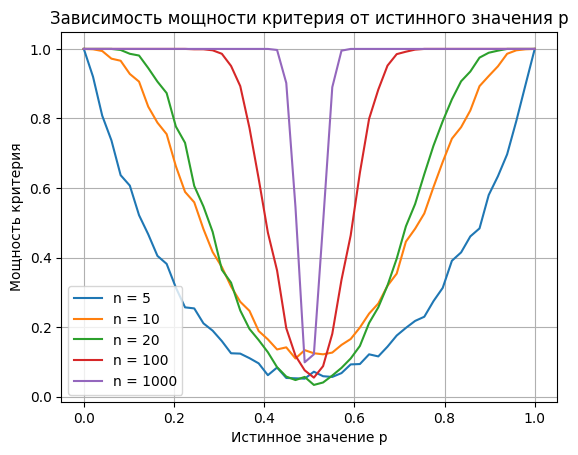

In [34]:
np.random.seed(42)

# ваш код
def simulate_power(n, p_true, p_0=0.5, alpha=0.05, n_simulations=1000):
    """Симуляция мощности критерия для заданного размера выборки и истинного значения p."""
    reject_count = 0
    for _ in range(n_simulations):
        sample = np.random.binomial(1, p_true, n)
        k = np.sum(sample)
        _, p_value = proportions_ztest(k, n, p_0)  # Используем proportions_ztest
        if p_value < alpha:
            reject_count += 1
    return reject_count / n_simulations

# Параметры симуляции
sample_sizes = [5, 10, 20, 100, 1000]
p_values = np.linspace(0, 1, 50)  # Истинные значения p от 0 до 1

# Симуляция и построение графиков
for n in sample_sizes:
    powers = [simulate_power(n, p) for p in p_values]
    plt.plot(p_values, powers, label=f"n = {n}")

plt.xlabel("Истинное значение p")
plt.ylabel("Мощность критерия")
plt.title("Зависимость мощности критерия от истинного значения p")
plt.legend()
plt.grid(True)
plt.show()


*Пункт 3*:

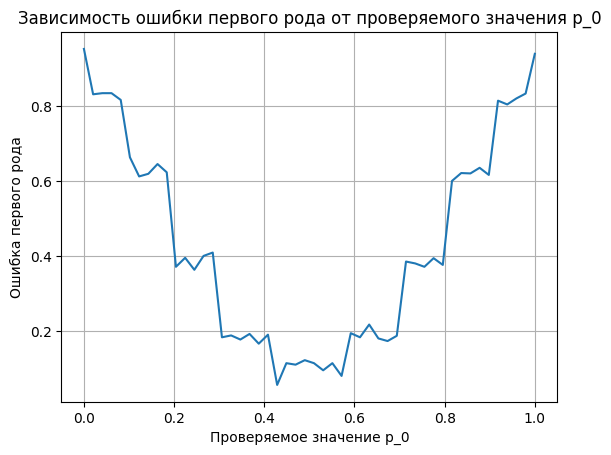

In [35]:
np.random.seed(42)

# ваш код
def simulate_type1_error(n, p_true=0.5, p_0_values=np.linspace(0, 1, 50), alpha=0.05, n_simulations=1000):
    """Симуляция ошибки первого рода для заданного размера выборки и истинного значения p."""
    type1_errors = []
    for p_0 in p_0_values:
        reject_count = 0
        for _ in range(n_simulations):
            sample = np.random.binomial(1, p_true, n)
            k = np.sum(sample)
            _, p_value = proportions_ztest(k, n, p_0)  # Используем proportions_ztest
            if p_value < alpha:
                reject_count += 1
        type1_errors.append(reject_count / n_simulations)
    return type1_errors

# Параметры симуляции
n = 10
p_0_values = np.linspace(0, 1, 50)

# Симуляция и построение графика
type1_errors = simulate_type1_error(n, p_0_values=p_0_values)
plt.plot(p_0_values, type1_errors)
plt.xlabel("Проверяемое значение p_0")
plt.ylabel("Ошибка первого рода")
plt.title("Зависимость ошибки первого рода от проверяемого значения p_0")
plt.grid(True)
plt.show()


### **Задание 2. Проверка нормальности распределение (Эксперимент Майкельсона)**

**Michelson A.A. Experimental determination of the velocity of light made at the U.S. Naval Academy, Annapolis. Astronomical Papers, 1, 109-145, 1880.**

Опыты Майкельсона — класс физических экспериментов, исследующих зависимость скорости распространения света от направления.

Проверим данные классического эксперимента Майкельсона по измерению скорости света с помощью вращающегося зеркала, 100 наблюдений на нормальность.

In [36]:
speed = [299850, 299740, 299900, 300070, 299930, 299850, 299950, 299980, 299980, 299880, 300000, 299980, 299930, 299650, 299760, 299810, 300000, 300000, 299960, 299960, 299960, 299940, 299960, 299940, 299880, 299800, 299850, 299880, 299900, 299840, 299830, 299790, 299810, 299880, 299880, 299830, 299800, 299790, 299760, 299800, 299880, 299880, 299880, 299860, 299720, 299720, 299620, 299860, 299970, 299950, 299880, 299910, 299850, 299870, 299840, 299840, 299850, 299840, 299840, 299840, 299890, 299810, 299810, 299820, 299800, 299770, 299760, 299740, 299750, 299760, 299910, 299920, 299890, 299860, 299880, 299720, 299840, 299850, 299850, 299780, 299890, 299840, 299780, 299810, 299760, 299810, 299790, 299810, 299820, 299850, 299870, 299870, 299810, 299740, 299810, 299940, 299950, 299800, 299810, 299870]



##### Гистограма распределения

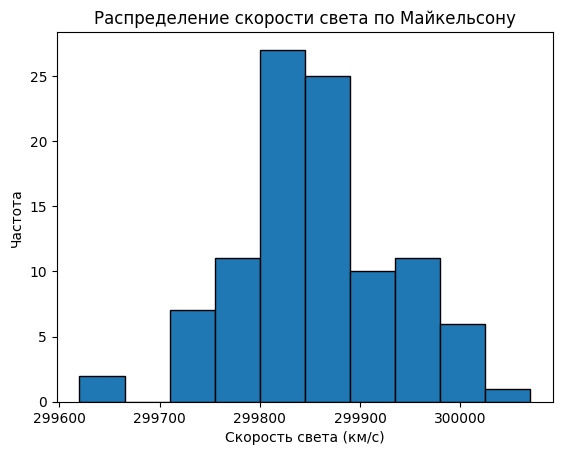

In [37]:
# ваш код

plt.hist(speed, bins=10, edgecolor='black')
plt.xlabel('Скорость света (км/с)')
plt.ylabel('Частота')
plt.title('Распределение скорости света по Майкельсону')
plt.show()


Проверка нормальности

**Q-Q диаграма**

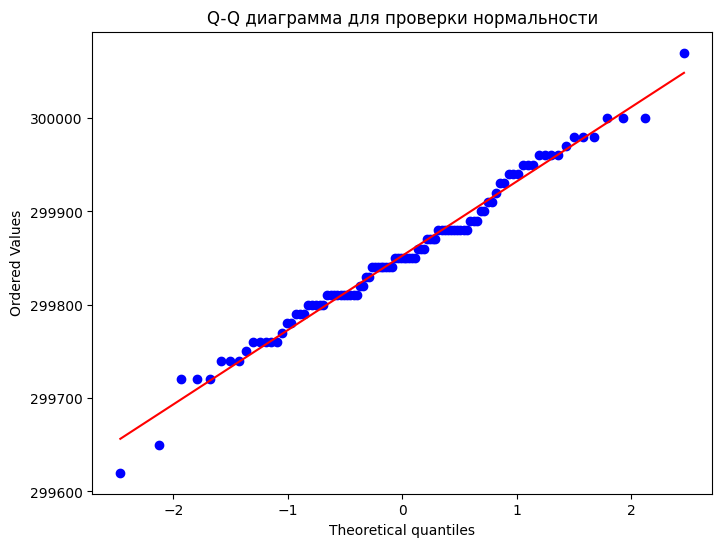

In [38]:
# ваш код
plt.figure(figsize=(8, 6))
st.probplot(speed, dist="norm", plot=plt)
plt.title("Q-Q диаграмма для проверки нормальности")
plt.show()

**Критерии Колмогорова-Смирнова (Лиллиефорса для нормального распределения)**

In [39]:
ks_statistic, ks_p_value = st.kstest(speed, 'norm', args=(np.mean(speed), np.std(speed)))
print(f"Критерий Колмогорова-Смирнова: статистика = {ks_statistic:.3f}, p-значение = {ks_p_value:.3f}")
if ks_p_value > 0.05:
    print("Вывод: Нет оснований отвергать гипотезу о нормальности распределения (p > 0.05).")
else:
    print("Вывод: Распределение, вероятно, отличается от нормального (p <= 0.05).")



Критерий Колмогорова-Смирнова: статистика = 0.083, p-значение = 0.475
Вывод: Нет оснований отвергать гипотезу о нормальности распределения (p > 0.05).


**Критерий Шапиро-Уилка**

In [40]:
shapiro_statistic, shapiro_p_value = st.shapiro(speed)
print(f"Критерий Шапиро-Уилка: статистика = {shapiro_statistic:.3f}, p-значение = {shapiro_p_value:.3f}")
if shapiro_p_value > 0.05:
    print("Вывод: Нет оснований отвергать гипотезу о нормальности распределения (p > 0.05).")
else:
    print("Вывод: Распределение, вероятно, отличается от нормального (p <= 0.05).")



Критерий Шапиро-Уилка: статистика = 0.988, p-значение = 0.514
Вывод: Нет оснований отвергать гипотезу о нормальности распределения (p > 0.05).


**Критерий Харке-Бера**

In [41]:
jb_statistic, jb_p_value = st.jarque_bera(speed)
print(f"Критерий Харке-Бера: статистика = {jb_statistic:.3f}, p-значение = {jb_p_value:.3f}")
if jb_p_value > 0.05:
    print("Вывод: Нет оснований отвергать гипотезу о нормальности распределения (p > 0.05).")
else:
    print("Вывод: Распределение, вероятно, отличается от нормального (p <= 0.05).")

Критерий Харке-Бера: статистика = 0.295, p-значение = 0.863
Вывод: Нет оснований отвергать гипотезу о нормальности распределения (p > 0.05).


### **Задание 3. Сравнение выборок. Разрушители легенд: тыльная сторона руки**

*Часть 1.* В 5 серии 13 сезона передачи “Разрушители легенд” проверялась справедливость выражения “know something like the back of one’s hand”. 

В эксперименте принимало участие 12 испытуемых. Каждому из них были предъявлены 10 фотографий похожих рук разных людей, среди которых они должны были угадать свою.
1. При предявлении фотографий тыльной стороны 11 из 12 испытуемых выбрали свою фотографию.
2. При предявлении фотографий ладони 7 из 12 испытуемых угадали свою фотографию.

Проверьте следующие предположения: 
1. Испытуемые выбирают фотографию тыльной стороны своей руки осознанно
2. Испытуемые выбирают фотографию своей ладони осознанно
3. Можно ли утверждать, что тыльную сторону руки люди знают лучше, чем ладонь? Сравним результаты экспериментов.




**Решение**

*Пункт 1.* Испытуемые выбирают фотографию тыльной стороны своей руки осознанно

* $H_0$: испытуемые выбирают фотографии тыльной стороны руки наугад (p=0.1).
* $H_1$: испытуемые выбирают фотографию тыльной стороны своей собственной руки осознанно (p>0.1).


In [42]:
import math
from scipy.stats import norm

def test_hypothesis(n, x, p0, alternative="greater"):
    """
    Проверяет гипотезу о пропорции с использованием одновыборочного z-теста.

    Args:
        n: Размер выборки.
        x: Количество успехов в выборке.
        p0: Предполагаемая пропорция в нулевой гипотезе.
        alternative:  Тип альтернативной гипотезы: "greater" (больше), "less" (меньше) или "two-sided" (двусторонняя).

    Returns:
        p_value:  p-значение теста.
    """
    p_hat = x / n
    se = math.sqrt(p0 * (1 - p0) / n)
    z = (p_hat - p0) / se

    if alternative == "greater":
        p_value = 1 - norm.cdf(z)
    elif alternative == "less":
        p_value = norm.cdf(z)
    elif alternative == "two-sided":
        p_value = 2 * (1 - abs(norm.cdf(z)))
    else:
        raise ValueError("Неверное значение для 'alternative'. Допустимые значения: 'greater', 'less', 'two-sided'.")

    return p_value

# Параметры эксперимента
n = 12
p0 = 0.1
alpha = 0.05  # Уровень значимости

# Пункт 1: Тыльная сторона руки
x1 = 11
p_value1 = test_hypothesis(n, x1, p0, "greater")
print(f"Пункт 1: p-значение для тыльной стороны руки: {p_value1}")
if p_value1 < alpha:
    print("  Отвергаем H0: Испытуемые выбирают осознанно.")
else:
    print("  Не отвергаем H0: Нет достаточных оснований утверждать, что выбирают осознанно.")

# Пункт 2: Ладонь
x2 = 7
p_value2 = test_hypothesis(n, x2, p0, "greater")
print(f"Пункт 2: p-значение для ладони: {p_value2}")
if p_value2 < alpha:
    print("  Отвергаем H0: Испытуемые выбирают осознанно.")
else:
    print("  Не отвергаем H0: Нет достаточных оснований утверждать, что выбирают осознанно.")

# Пункт 3: Сравнение результатов (неформальное сравнение p-значений)
print("Пункт 3: Сравнение результатов")
if p_value1 < p_value2:
    print("  Результаты для тыльной стороны руки более статистически значимы (меньшее p-значение).")
elif p_value1 > p_value2:
    print("  Результаты для ладони более статистически значимы (меньшее p-значение).")
else:
    print("  Статистическая значимость результатов для тыльной стороны и ладони одинакова.")

#  Для более строгого сравнения можно использовать тест для разности пропорций,
#  но в данном примере ограничимся сравнением p-значений.


Пункт 1: p-значение для тыльной стороны руки: 0.0
  Отвергаем H0: Испытуемые выбирают осознанно.
Пункт 2: p-значение для ладони: 1.1953366074735072e-08
  Отвергаем H0: Испытуемые выбирают осознанно.
Пункт 3: Сравнение результатов
  Результаты для тыльной стороны руки более статистически значимы (меньшее p-значение).


[**Доверительный интервал Уилсона**](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) - интервальная оценка вероятности успеха $p$ для биномиального распределения, если известны только количество экспериментов $n$ и количество успехов $T$. 

In [43]:
proportion_confint(x1, n, method='wilson')


(0.646120088858883, 0.9851349055950829)

In [44]:
proportion_confint(x2, n, method='wilson')

(0.31951131254954973, 0.8067396863412435)

*Пункт 2.* Испытуемые выбирают фотографию своей ладони осознанно.

In [55]:
def test_hypothesis(n, x, p0, alternative="less"):  # Изменено на "less"
    """
    Проверяет гипотезу о пропорции с использованием одновыборочного z-теста.

    Args:
        n: Размер выборки.
        x: Количество успехов в выборке.
        p0: Предполагаемая пропорция в нулевой гипотезе.
        alternative:  Тип альтернативной гипотезы: "greater" (больше), "less" (меньше) или "two-sided" (двусторонняя).

    Returns:
        p_value:  p-значение теста.
    """
    p_hat = x / n
    se = math.sqrt(p0 * (1 - p0) / n)
    z = (p_hat - p0) / se

    if alternative == "greater":
        p_value = 1 - norm.cdf(z)
    elif alternative == "less":
        p_value = norm.cdf(z)
    elif alternative == "two-sided":
        p_value = 2 * (1 - abs(norm.cdf(z)))
    else:
        raise ValueError("Неверное значение для 'alternative'. Допустимые значения: 'greater', 'less', 'two-sided'.")

    return p_value

# Параметры для ладони
n = 12
x = 7
p0 = 0.1
alternative = "less"  # Изменено на "less"

# Выполнение теста
p_value = test_hypothesis(n, x, p0, alternative)

print(f"p-значение для проверки гипотезы о ладони: {p_value}")

# Интерпретация:
alpha = 0.05  # Уровень значимости
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: нет достаточных оснований полагать, что испытуемые выбирают фотографию своей ладони осознанно.")  # Изменена интерпретация
else:
    print("Не отвергаем нулевую гипотезу: есть основания полагать, что испытуемые выбирают фотографию своей ладони осознанно.")  # Изменена интерпретация


p-значение для проверки гипотезы о ладони: 0.9999999880466339
Не отвергаем нулевую гипотезу: есть основания полагать, что испытуемые выбирают фотографию своей ладони осознанно.


*Пункт 3*. Проверка предположения, что тыльную сторону руки люди знают лучше, чем ладонь?

Обратите внимание, что выборки савязанные, так как это одни и те же испытуемые, но информации о связности нет.
Поэтому мы вынуждены использовать критерии для независимых выборок.

In [54]:
# ваш код
def compare_proportions(n1, x1, n2, x2, alternative="greater"):
    """
    Сравнивает две пропорции с использованием z-теста для разности пропорций.

    Args:
        n1: Размер выборки 1.
        x1: Количество успехов в выборке 1.
        n2: Размер выборки 2.
        x2: Количество успехов в выборке 2.
        alternative: Тип альтернативной гипотезы: "greater" (больше), "less" (меньше) или "two-sided" (двусторонняя).

    Returns:
        p_value: p-значение теста.
    """
    p1_hat = x1 / n1
    p2_hat = x2 / n2
    p_hat = (x1 + x2) / (n1 + n2)
    se = math.sqrt(p_hat * (1 - p_hat) * (1/n1 + 1/n2))
    z = (p1_hat - p2_hat) / se

    if alternative == "greater":
        p_value = 1 - norm.cdf(z)
    elif alternative == "less":
        p_value = norm.cdf(z)
    elif alternative == "two-sided":
        p_value = 2 * (1 - abs(norm.cdf(z)))
    else:
        raise ValueError("Неверное значение для 'alternative'. Допустимые значения: 'greater', 'less', 'two-sided'.")

    return p_value

# Параметры эксперимента
n1 = 12
x1 = 11
n2 = 12
x2 = 7
alternative = "greater"

# Выполнение теста
p_value = compare_proportions(n1, x1, n2, x2, alternative)

print(f"p-значение для сравнения пропорций: {p_value}")

# Интерпретация:
alpha = 0.05  # Уровень значимости
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: есть основания полагать, что люди лучше знают тыльную сторону своей руки, чем ладонь.")
else:
    print("Не отвергаем нулевую гипотезу: нет достаточных оснований полагать, что люди лучше знают тыльную сторону своей руки, чем ладонь.")


p-значение для сравнения пропорций: 0.029673219395960015
Отвергаем нулевую гипотезу: есть основания полагать, что люди лучше знают тыльную сторону своей руки, чем ладонь.


### **Задание 4. Сравнение выборок. Терапия при анорексии**

**Everitt N., McMahon M. (2004). Nutrition and the surgical patient. In Consensus in Clinical Nutrition, Cambridge: Cambridge University Press.**

В исследовании оценивается эффективность поведенческой терапии для лечения анорексии. Для 50 пациентов известен вес до начала терапии и по её окончании. Была ли терапия эффективной?

In [87]:
data = {
    'До':[80.50, 84.90, 81.50, 82.60, 79.90, 88.70, 94.90, 76.30, 81.00, 80.50, 85.00, 89.20, 81.30, 76.50, 70.00, 80.40, 83.30, 83.00, 87.70, 84.20, 86.40, 76.50, 80.20, 87.80, 83.30, 79.70, 84.50, 80.80, 87.40],
    'После': [82.20, 85.60, 81.40, 81.90, 76.40, 103.6, 98.40, 93.40, 73.40, 82.10, 96.70, 95.30, 82.40, 72.50, 90.90, 71.30, 85.40, 81.60, 89.10, 83.90, 82.70, 75.70, 82.60, 100.4, 85.20, 83.60, 84.60, 96.20, 86.70]
}
data = pd.DataFrame.from_dict(data)
weight = data.values


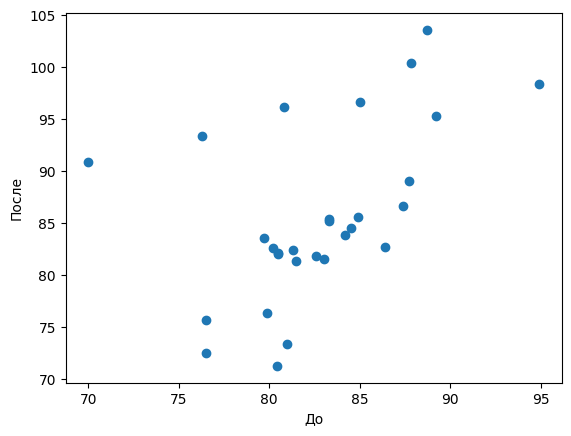

In [88]:
plt.scatter(data['До'], data['После'])
plt.xlabel('До')
plt.ylabel('После')

plt.show()

Пункты исследования
1. Проверьте распределение на нормальность
2. Проверьте гипотезу о общем увеличении веса под влиянием терапии
3. Проверьте гипотезу о влиянии терапии на средний вес
4. Проверьте гипотезу о влиянии терапии на медианный вес
4. Найдите доверительные интервалы для среднего и медианного среднего прироста веса

In [91]:
# Тест Шапиро-Уилка для веса "До"
shapiro_before = st.shapiro(data['До'])
print(f"Тест Шапиро-Уилка для веса 'До': {shapiro_before.pvalue:.3f}")

# Тест Шапиро-Уилка для веса "После"
shapiro_after = st.shapiro(data['После'])
print(f"Тест Шапиро-Уилка для веса 'После': {shapiro_after.pvalue:.3f}")


Тест Шапиро-Уилка для веса 'До': 0.558
Тест Шапиро-Уилка для веса 'После': 0.206


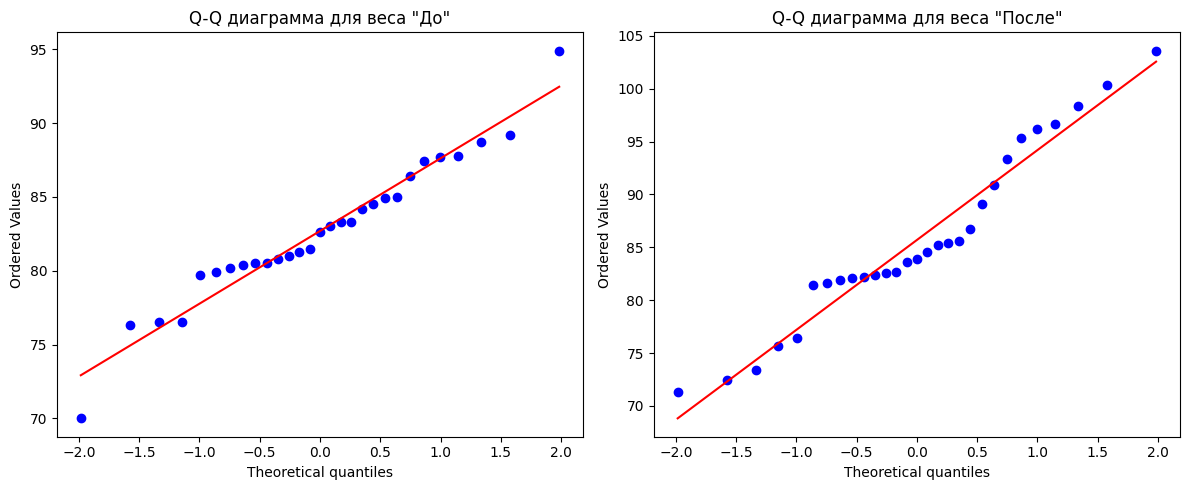

In [ ]:
# Пункт 1
# Q-Q диаграмма для веса "До"
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
st.probplot(data['До'], dist="norm", plot=plt)
plt.title('Q-Q диаграмма для веса "До"')

# Q-Q диаграмма для веса "После"
plt.subplot(1, 2, 2)
st.probplot(data['После'], dist="norm", plot=plt)
plt.title('Q-Q диаграмма для веса "После"')

plt.tight_layout()
plt.show()

In [84]:
# Пункт 2



In [ ]:
# Пункт 3


In [71]:
# Пункт 4



In [ ]:
# Пункт 5




### **Задание 5. Недвижимость в Сиэттле**

**Hesterberg T., Monaghan S., Moore D.S., Clipson A., Epstein R. (2005). Bootstrap methods and permutation tests. In Introduction to the Practice of Statistics, New York: W. H. Freeman and Company.** http://statweb.stanford.edu/~tibs/stat315a/Supplements/bootstrap.pdf

Имеются данные о продажной стоимости недвижимости в Сиэтле для 50 сделок в 2001 году и 50 в 2002. Изменились ли цены?

In [92]:
data = [     
    [142,2002], [232,2002], [132.5,2002], [200,2002], [362,2002], [244.95,2002], [335,2002], [324.5,2002], [222,2002], [225,2002], [175,2002], [50,2002], [215,2002], [260,2002], [307,2002], [210.95,2002], [1370,2002], [215.5,2002], [179.8,2002], [217,2002], [197.5,2002], [146.5,2002], [116.7,2002], [449.9,2002], [266,2002], [265,2002], [256,2002], [684.5,2002], [257,2002], [570,2002], [149.4,2002], [155,2002], [244.9,2002], [66.407,2002], [166,2002], [296,2002], [148.5,2002], [270,2002], [252.95,2002], [507,2002], [705,2002], [1850,2002], [290,2002], [164.95,2002], [375,2002], [335,2002], [987.5,2002], [330,2002], [149.95,2002], [190,2002], [419,2001], [55.268,2001], [65,2001], [210,2001], [510.728,2001], [212.2,2001], [152.720,2001], [266.6,2001], [69.427,2001], [125,2001], [191,2001], [451,2001], [469,2001], [310,2001], [325,2001], [50,2001], [675,2001], [140,2001], [105.5,2001], [285,2001], [320,2001], [305,2001], [255,2001], [95.179,2001], [346,2001], [199,2001], [450,2001], [280,2001], [205.5,2001], [135,2001], [190,2001], [452.5,2001], [335,2001], [455,2001], [291.905,2001], [239.9,2001], [369.95,2001], [569,2001], [481,2001], [475,2001], [495,2001], [195,2001], [237.5,2001], [143,2001], [218.95,2001], [239,2001], [710,2001], [172,2001], [228.5,2001], [270,2001],
]
data = pd.DataFrame(data=data, columns=['Цена','Год'])

In [94]:
## Ваш код
# Разделение данных
price_2001 = data[data['Год'] == 2001]['Цена']
price_2002 = data[data['Год'] == 2002]['Цена']

# Проверка нормальности
shapiro_2001 = st.shapiro(price_2001)
shapiro_2002 = st.shapiro(price_2002)
print(f"Тест Шапиро-Уилка (2001): p-value = {shapiro_2001.pvalue:.3f}")
print(f"Тест Шапиро-Уилка (2002): p-value = {shapiro_2002.pvalue:.3f}")

# Проверка гомогенности дисперсий
levene_test = st.levene(price_2001, price_2002)
print(f"Тест Левена: p-value = {levene_test.pvalue:.3f}")

# Двухвыборочный t-тест (равные дисперсии не предполагаются)
# t_test = st.ttest_ind(price_2001, price_2002, equal_var=False)
# print(f"Двухвыборочный t-тест: p-value = {t_test.pvalue:.3f}")

# Если данные не нормальны, используем тест Манта-Уитни
mannwhitney = st.mannwhitneyu(price_2001, price_2002)
print(f"Тест Манта-Уитни: p-value = {mannwhitney.pvalue:.3f}")

Тест Шапиро-Уилка (2001): p-value = 0.039
Тест Шапиро-Уилка (2002): p-value = 0.000
Тест Левена: p-value = 0.445
Тест Манта-Уитни: p-value = 0.756


## **Задание 6. Критерий Вальда**

Критерий Вальда для проверки гипотезы $H_0\colon \theta=\theta_0$ против  $H_1\colon \theta <\neq>\theta_0$ 
Имеет вид  
$$
Z_W\left(X^n\right) = \frac{\hat{\theta}_{MLE} - \theta_0}{\sqrt{\mathbb D \hat{\theta}_{MLE}}}\sim N\left(0,1\right)
$$
 
 Достигаемый уровень значимости:
$$
	p\left(Z_W\right) = \begin{cases}
		1-F_{N(0,1)}(Z_W), & H_1 \colon \theta>\theta_0, \\
		F_{N(0,1)}(Z_W), & H_1 \colon \theta<\theta_0, \\
		2\left(1-F_{N(0,1)}(|Z_W|)\right), & H_1 \colon \theta\neq\theta_0. \\
	\end{cases}
$$

Проведен эксперимент, получены данные из экспоненциального распределения. 

In [51]:
sample = [0.11731702, 0.75253036, 0.32918642, 0.22823564, 0.04240622,
        0.04239907, 0.01495969, 0.50280772, 0.22977054, 0.30781252,
        0.00519983, 0.87588937, 0.44660739, 0.05967191, 0.05016975,
        0.05065286, 0.09068843, 0.18598196, 0.14138427, 0.08605575,
        0.23659272, 0.03755863, 0.08637888, 0.1140693 , 0.15223367,
        0.384484  , 0.05568397, 0.18050729, 0.22437618, 0.01189096]

Необходимо проверить, является имеет ли это распределение параметр $\lambda=2$. 


Используя Критерий Вальда, проверьте гипотезу $\mathsf{H}_0\colon \lambda = 2$ против $\mathsf{H}_1\colon \lambda \neq 2$  
  

Считая известным, что $\lambda_{MLE} = \frac{1}{\overline{X}}$ - асимптотически нормальная оценка для параметра $\theta$ c асимптотической дисперсией $\theta^2$.
 
 

In [52]:
# Ваш код

## **Задание 7. Оценка уровня значимости**
 критерий Вальда является примером асимптотического критерия. Такие критерии контролируют вероятность ошибки I рода на уровне $\alpha$ только в пределе, однако для небольших выборок она может сильно отличаться от $\alpha$, причем нередко в большую сторону. Поэтому для асимптотических критериев возникает необходимость в вычислении оценки значения вероятности ошибки I рода или *оценки реального уровня значимости* при конечной выборке.

Вот только как это сделать?

1. Опишите схему оценки реального уровня значимости.
2. Пусть $X_1, ..., X_n$ &mdash; выборка из пуассоновского распределения с параметром $\theta$. 
Рассмотрим гипотезу $\mathsf{H}_0\colon \theta = 1$ против $\mathsf{H}_1\colon \theta \not= 1$ и критерий Вальда для их проверки. Оцените реальный уровень значимости критерия для $n = 50$.


In [53]:
# Ваш код: